#### Required Modules

In [25]:
import pandas as pd
from scipy.io import arff
import pycountry
import matplotlib.pyplot as plt

#### Load Datasets

In [26]:
# Expect a `data` directory
DATA_DIRECTORY = "./data/"

def load_from_arff(filename: str) -> pd.DataFrame:
    """
    Load ARFF data and build it into a Pandas DataFrame.
    """
    data, _ = arff.loadarff(DATA_DIRECTORY + filename)
    df = pd.DataFrame(data)
    return df

#### Dataset Selection

| Dataset | Description | Issues | Selected |
|---------|-------------|--------|----------|
| Poisonous Mushrooms | Manually compiled features of forages mushrooms. | No pre-processing required. | No |
| Airline Departure Delays | Time and location of flight departures. | No pre-processing required. | No |
| Mortgage Application Outcomes | Applicant information, application process results | All data is numeric with not keys for categories. Some categorical data is type `float`. | No |
| Wine Reviews | Reviews and ratings of wines from a specified location. | ARFF has format issues in `str` column. | **Yes** |

#### Wine Review Data

Libraries `scipy` and `liac-arff` fail to import the data.
SciPy complains it can not handle string columns, and LIAC-ARFF complains about the file format.

**Solution:** Manually reformatted file by rearranging ARFF features into a CSV column name row.

In [27]:
WINE_ARFF = "wine.arff"
WINE_CSV = "wine.csv"

# df = load_from_arff(WINE_ARFF)
df = pd.read_csv(DATA_DIRECTORY + WINE_CSV,
    sep=",",
    quotechar="'",
    escapechar="\\",
    engine="python")

df.head()

,country,description,points,price,province,variety
0,US,"This is a tight, black-fruited wine, with gene...",92,28.0,Washington,Cabernet Franc
1,US,A nice starter Pinot for the price. Will intro...,86,14.0,California,Pinot Noir
2,Spain,Raw aromas of rhubarb and scratchy raspberry o...,83,15.0,Northern Spain,Tempranillo
3,Germany,This wine comes out of the bottle a little cra...,90,18.0,Mosel-Saar-Ruwer,Riesling
4,South Africa,Winemaker: Jacques Borman. There's a ton of he...,90,?,Stellenbosch,Shiraz


#### Rename Columns

- Prepend the dataset name `WINE`.
- Replace spaces with underscores `_`.
- Add column type (whether it is `INPUT` or `LABEL`).
- Capitalize column names.

In [28]:
old_names = df.columns.tolist()
new_names = ["INPUT_" + name for name in old_names[:-1]] + ["LABEL_" + old_names[-1]]
new_names = ["WINE_" + name.upper() for name in new_names]
df.columns = new_names

#### Cleaning Location Columns

In [29]:
country_column = 'WINE_EXTRA_COUNTRY_NAME'
df = df.rename(
    columns={'WINE_INPUT_COUNTRY': country_column})
print(len(df[country_column].dropna().unique()))
print(sorted(df[country_column].dropna().unique()))

41
['?', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'Croatia', 'Cyprus', 'Czech Republic', 'England', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Israel', 'Italy', 'Lebanon', 'Luxembourg', 'Macedonia', 'Mexico', 'Moldova', 'Morocco', 'New Zealand', 'Peru', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Switzerland', 'Turkey', 'US', 'Ukraine', 'Uruguay']


In [30]:
def to_code(name: str) -> str:
    """
    Get country code from name.
    Replace '?' with None.
    """
    try:
        return pycountry.countries.lookup(name).alpha_2
    except LookupError:
        if name == "England":
            return "GB"
        elif name == "Turkey":
            return "TR"
        elif name == "Macedonia":
            return "MK"
        else:
            return None

code_column = "WINE_INPUT_COUNTRY_CODE"
df[code_column] = df[country_column].apply(to_code)
print(len(
    df[code_column].dropna().unique()))
print(sorted(df[code_column].dropna().unique()))

40
['AM', 'AR', 'AT', 'AU', 'BG', 'BR', 'CA', 'CH', 'CL', 'CY', 'CZ', 'DE', 'ES', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IL', 'IN', 'IT', 'LB', 'LU', 'MA', 'MD', 'MK', 'MX', 'NZ', 'PE', 'PT', 'RO', 'RS', 'SI', 'SK', 'TR', 'UA', 'US', 'UY', 'ZA']


Check no data was lost.

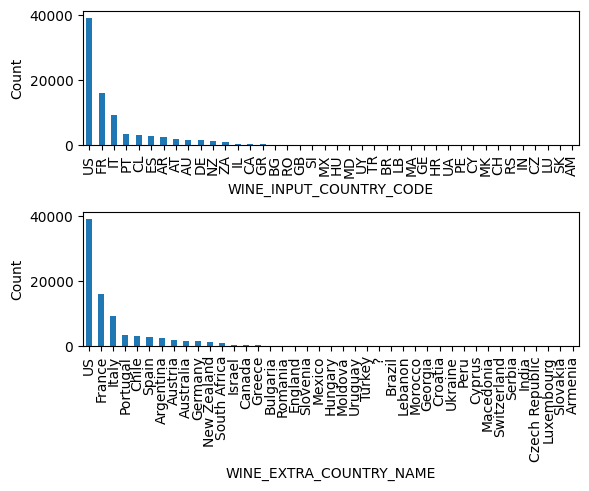

In [31]:
figure, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(6, 5),
    sharex=False)

country_columns = [code_column, country_column]
for axis, column in zip(axes, country_columns):
    df[column].value_counts().plot(
        kind='bar',
        ax=axis,
        rot=90)
    axis.set_ylabel('Count')

plt.tight_layout()
plt.show()

Check `None` values match unknowns.

In [32]:
null = df[code_column].isnull().sum()
unknown = df[country_column].value_counts().get('?', 0)

assert null == unknown

Replace `?` values with `None` for provinces. 

In [33]:
province_column = 'WINE_INPUT_PROVINCE'

unknown = df[province_column].value_counts().get('?', 0)

df[province_column] = df[province_column].replace('?', pd.NA)
null = df[province_column].isnull().sum()

assert null == unknown

Add column that track null rows in either location columns.

In [39]:
location_null = 'WINE_EXTRA_LOCATION_IS_NULL'
df[location_null] = df[code_column].isnull() | df[province_column].isnull()

print(
    'Null values in location columns:',
    sum(df[location_null]))

Null values in location columns: 33
